In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("/home/mwirth/projects/sound-seperation")
os.getcwd()

'/home/mwirth/projects/sound-seperation'

In [3]:
from hydra import compose, initialize
from hydra.utils import instantiate
from tqdm.notebook import tqdm
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
import torch
import soundfile as sf
import librosa
from src.modules.models.tdcnn import TDConvNetpp, WaveformEncoder, WaveformDecoder
from src.datamodules.components.normalization import NormalizePeak

In [5]:
def pad_to_length(arr, target_length=80000):
    current_length = len(arr)
    if current_length == target_length:
        return arr
    # Calculate padding
    padding_length = target_length - current_length
    padded_array = np.pad(arr, (0, padding_length), 'constant', constant_values=0)
    return padded_array

In [125]:
ds_name = "HSN_scape"
cache_dir = f"data/{ds_name}"
ds = load_dataset("DBD-research-group/BirdSet", ds_name, cache_dir=cache_dir, trust_remote_code=True, split="test_5s")

In [126]:
encoder = WaveformEncoder(256, 256)
decoder = WaveformDecoder(256, 256)
#normalize = NormalizePeak(0.25)
model = TDConvNetpp(in_chan=256, n_src=4, n_repeats=4, encoder=encoder, decoder=decoder)

In [127]:
#checkpoint = "/home/mwirth/projects/sound-seperation/checkpoints/new/epoch015-loss_valid-10.6268-metric_valid10.6287.ckpt"
checkpoint = "/home/mwirth/projects/sound-seperation/checkpoints/new/epoch013-loss_valid-11.2518-metric_valid11.2493.ckpt"
#checkpoint = "/home/mwirth/projects/sound-seperation/checkpoints/new/epoch059-xcm_no_normal-loss_valid-10.4859-metric_valid10.4858.ckpt"
state_dict = torch.load(checkpoint, weights_only=False)
state_dict = {k[6:]: v for k, v in state_dict["state_dict"].items()}
model.load_state_dict(state_dict)
model = model.eval()

In [172]:
data = ds[8100]
print(data["ebird_code_multilabel"])
wave, sr = librosa.load(data["filepath"], sr=16000)
with torch.no_grad():
    #wave = normalize(wave)
    wave = pad_to_length(wave, target_length=160_000) # pad to 10s audio
    wave = torch.tensor(wave).unsqueeze(0).float()
    masks, est_wave, weights = model(wave)
    wave = wave[:,:80000]
    est_wave = est_wave[:,:,:80000]
weights

[1]


tensor([[0.3791, 0.3105, 0.0025, 0.3080]])

In [177]:
sf.write("HSN/2/orginal.flac", data=wave.flatten(), samplerate=16000)

In [173]:
Audio(wave, rate=16000, normalize=False)

In [178]:
for i in range(4):
    display(Audio(est_wave[:,i].flatten(), rate=16_000, normalize=False))
    sf.write(f"HSN/2/separation{i}.flac", data=est_wave[:,i].flatten(), samplerate=16000)

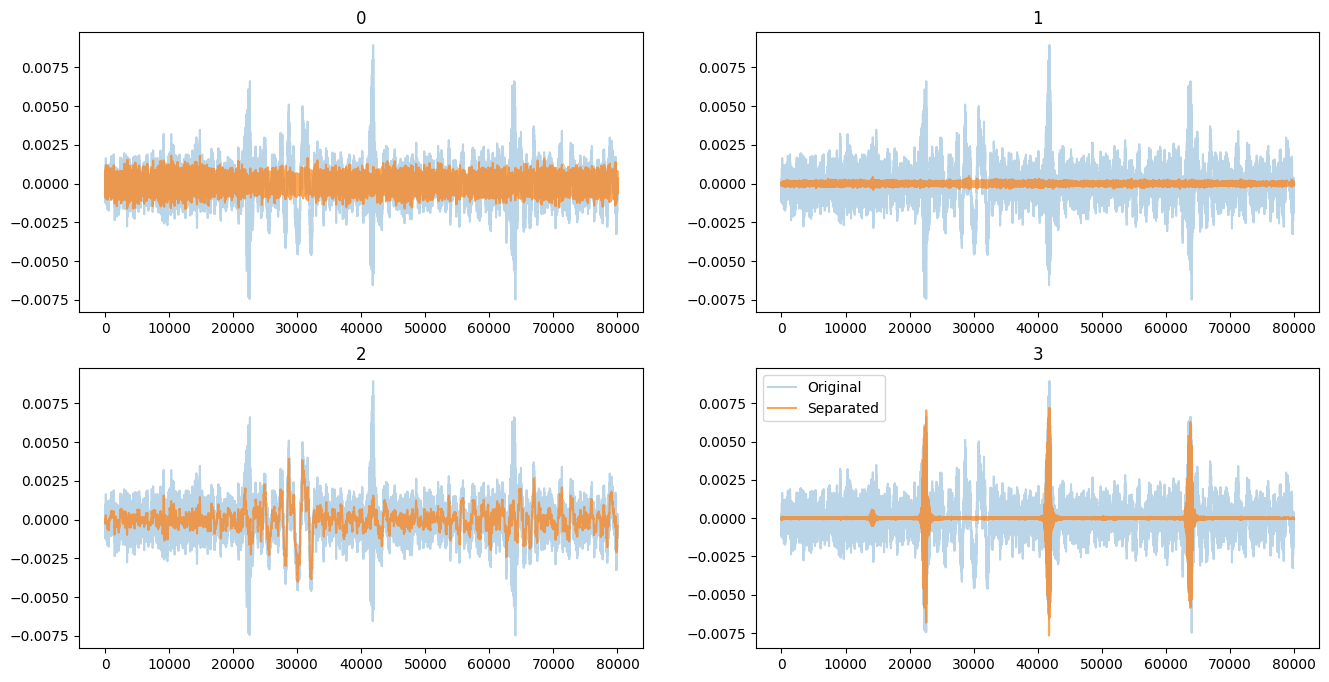

In [179]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
for i in range(est_wave.shape[1]):
    axes[i // 2][i%2].plot(wave.flatten(), alpha=0.3, label="Original")
    axes[i // 2][i%2].plot(est_wave[:,i].flatten(), alpha=0.7, label="Separated")
    axes[i // 2][i%2].set_title(f"{i}")
    #axes[i//2][i%2].vlines((data["start_time"] % 10)*16000, wave.flatten().min(), wave.flatten().max())
    #axes[i//2][i%2].vlines((data["end_time"] % 10)*16000, wave.flatten().min(), wave.flatten().max())
axes[-1][-1].legend()
plt.savefig("HSN/2/wave_plot.pdf")

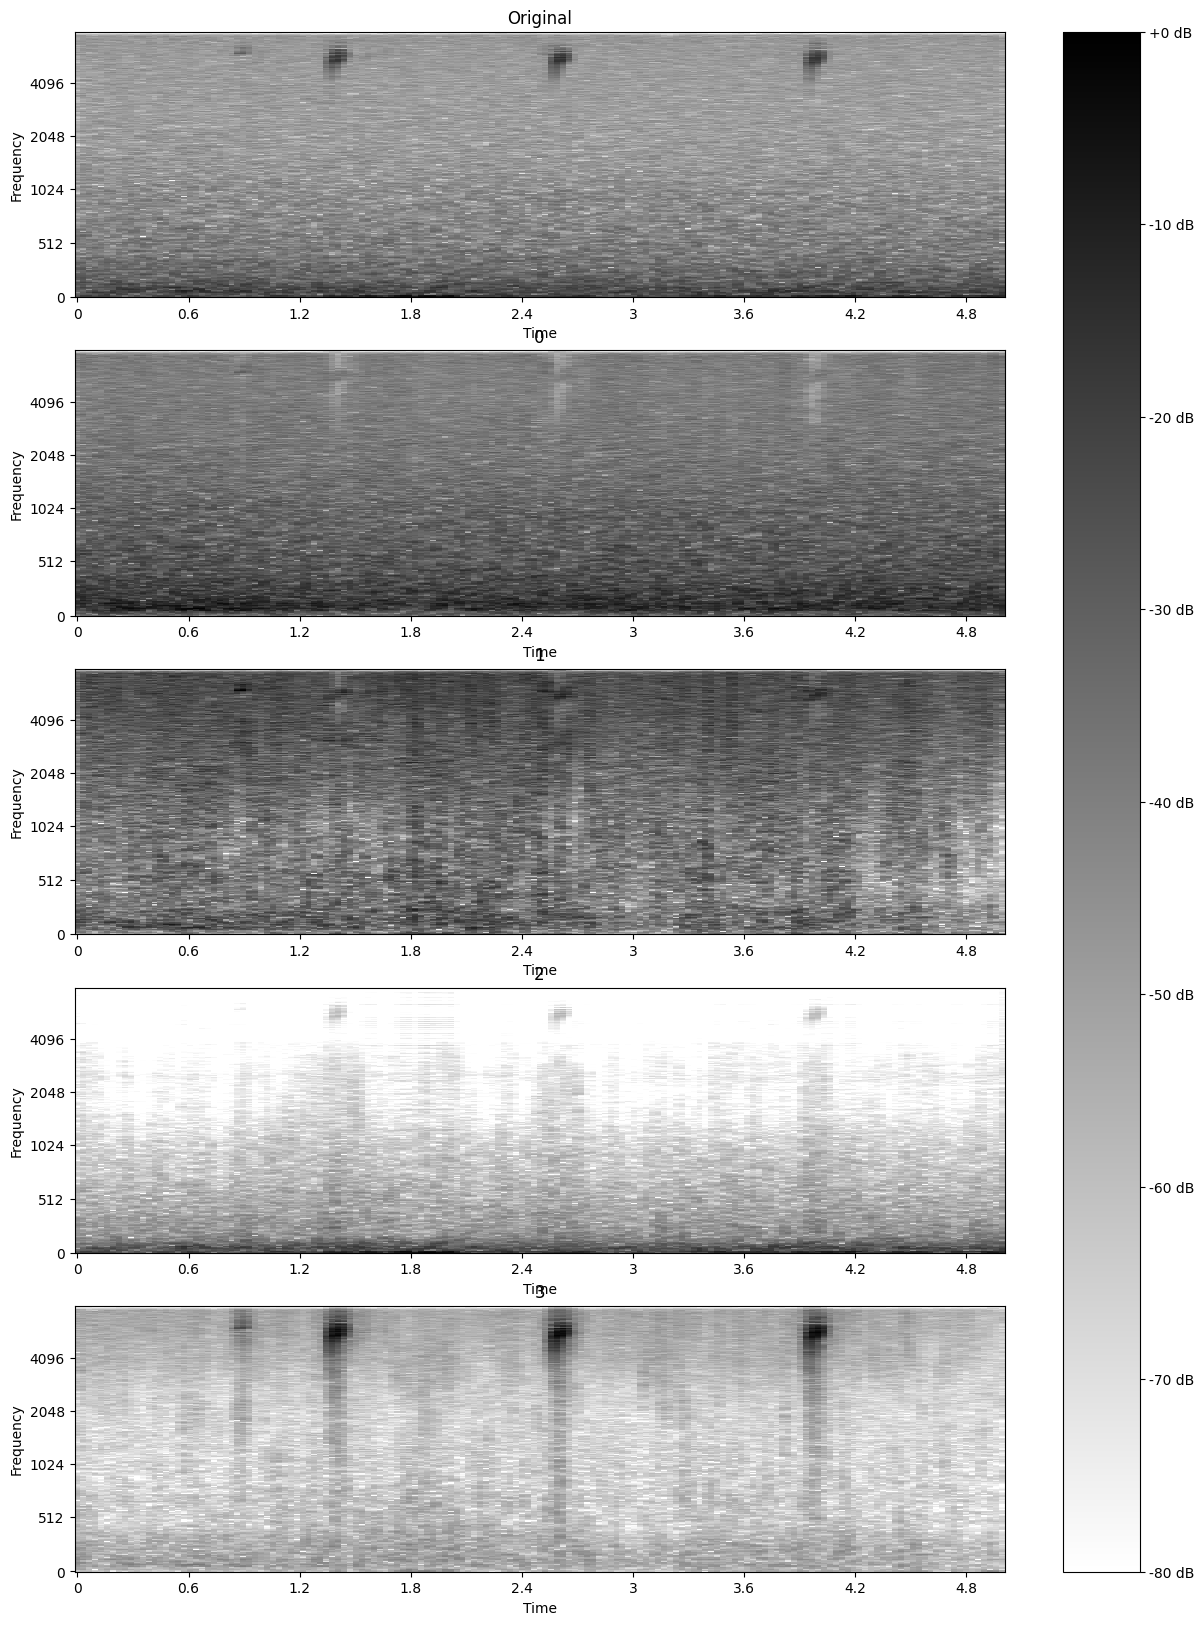

In [180]:
fig, axes = plt.subplots(5, 1, figsize=(15, 20))
S = librosa.feature.melspectrogram(y=wave.flatten().numpy(), sr=16000, n_mels=512)
S_db = librosa.power_to_db(S, ref=np.max)

# Overlay the spectrograms with different tints
img = librosa.display.specshow(S_db, sr=16000, ax=axes[0], x_axis='time', y_axis='mel', cmap="gray_r")

for i in range(1, est_wave.shape[1]+1):
    # Compute the spectrogram
    S = librosa.feature.melspectrogram(y=est_wave[:,i-1].flatten().numpy(), sr=16000, n_mels=512)
    S_db = librosa.power_to_db(S, ref=np.max)

    # Overlay the spectrograms with different tints
    img = librosa.display.specshow(S_db, sr=16000, ax=axes[i], x_axis='time', y_axis='mel', cmap="gray_r")
    

    axes[i].set_title(f"{i-1}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Frequency")

axes[0].set_title(f"Original")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Frequency")
fig.colorbar(img, ax=axes, format="%+2.0f dB")
plt.savefig("HSN/1/spectrogram_plot.pdf")
plt.show()